# Regional Analysis

Per gemeente analyseren we hoeveel observaties per km2 er in 2024 zijn gebeurd voor de halsbandparkiet en de boomklever. Ook kijken we naar de aantal unieke observators per gemeente, zodat 1 persoon de data niet kan bepalen. </br>
De conclusie is dat de boomklever veel meer wijd verspreid is dan de halsbandparkiet.</br>
De halsbandparkiet bevindt zich vooral rond Brussel, Antwerpen en Kortrijk </br>
De boomklever bevindt zich zowat in het hele land, met uitzondering van een gedeelte van de kust en een regio in Luik.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # Logaritmische verdeling
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
## Geodataframe gemeenten in belgië
belgium = gpd.read_file('../resources/geodata/kontur_boundaries_BE_20230628.gpkg')
belgium_gemeenten = belgium[(belgium["osm_admin_level"] == '8')].copy()
belgium_gemeenten.head(5)

,admin_level,osm_admin_level,name,name_en,population,hasc,geometry
55,9,8,Tenneville,None,2861.0,None,"MULTIPOLYGON (((5.39024 50.07851, 5.39032 50.0..."
56,9,8,Rendeux,None,2596.0,None,"MULTIPOLYGON (((5.44198 50.22504, 5.44237 50.2..."
57,9,8,Boechout,None,12318.0,None,"MULTIPOLYGON (((4.47911 51.16276, 4.47986 51.1..."
58,9,8,Ville de Bruxelles - Stad Brussel,Brussels,220447.0,None,"MULTIPOLYGON (((4.314 50.8934, 4.318 50.89451,..."
59,9,8,Spiere-Helkijn,None,1939.0,None,"MULTIPOLYGON (((3.32376 50.72324, 3.32429 50.7..."


In [ ]:
## Geodataframe waarnemingen halsbandparkiet en boomklever
halsbandparkiet = f'../3_scaling/scaled_data/observations_halsbandparkiet_scaled.parquet'
boomklever = f'../3_scaling/scaled_data/observations_boomklever_scaled.parquet'
period = list(range(2015,2025,1))

# Load the data from the period
df_halsbandparkiet = pd.read_parquet(halsbandparkiet, engine="pyarrow")
df_halsbandparkiet_period = df_halsbandparkiet[df_halsbandparkiet['year'].isin(period)].reset_index().copy()
geometry_hp = gpd.points_from_xy(df_halsbandparkiet_period['longitude'], df_halsbandparkiet_period['latitude'])
gpd_hp_period = gpd.GeoDataFrame(df_halsbandparkiet_period, geometry=geometry_hp, crs="EPSG:4326")

df_boomklever = pd.read_parquet(boomklever, engine="pyarrow")
df_boomklever_period = df_boomklever[df_boomklever['year'].isin(period)].copy()
geometry_bk = gpd.points_from_xy(df_boomklever_period['longitude'], df_boomklever_period['latitude'])
gpd_bk_period = gpd.GeoDataFrame(df_boomklever_period, geometry=geometry_bk, crs="EPSG:4326")

# Voer een ruimtelijke join uit om waarnemingen te koppelen aan gemeenten
gdf_merged_hp = gpd.sjoin(gpd_hp_period, belgium_gemeenten, how="right", predicate="within")
gdf_merged_bk = gpd.sjoin(gpd_bk_period, belgium_gemeenten, how="right", predicate="within")

# Stap 5: Tel het aantal waarnemingen per gemeente en jaar
hp_per_gemeente = gdf_merged_hp.groupby(["name", "year"]).agg({'observation_count_sc': 'sum', 'observer_id': 'nunique', 'observation_id': 'nunique'}).rename(columns={'observation_count_sc': 'hp_observations_sc','observation_id': 'hp_observations_abs', 'observer_id':'hp_observers_abs'}).reset_index()
bk_per_gemeente = gdf_merged_bk.groupby(["name", "year"]).agg({'observation_count_sc': 'sum', 'observer_id': 'nunique', 'observation_id': 'nunique'}).rename(columns={'observation_count_sc': 'bk_observations_sc','observation_id': 'bk_observations_abs', 'observer_id':'bk_observers_abs'}).reset_index()

# Create a DataFrame with all combinations of 'name' and 'year'
all_names = belgium_gemeenten['name'].unique()
all_years = period
all_combinations = pd.MultiIndex.from_product([all_names, all_years], names=["name", "year"]).to_frame(index=False)

# Merge gemeente en jaar met de observaties van de halsbandparkieten en boomklevers per gemeente
vogels_per_gemeente = all_combinations.merge(hp_per_gemeente, on=["name", "year"], how='left').merge(bk_per_gemeente, on=["name", "year"], how='left')

# Fill NaN values with 0
vogels_per_gemeente.fillna(0, inplace=True)

# Stap 2: Voeg geometrie terug toe vanuit het oorspronkelijke gemeenten-GeoDataFrame
vogels_per_gemeente = vogels_per_gemeente.merge(
    belgium_gemeenten[['name', 'geometry']], on='name', how='outer'
)

# Stap 3: Zorg dat het een GeoDataFrame blijft
vogels_per_gemeente = gpd.GeoDataFrame(vogels_per_gemeente, geometry='geometry', crs="EPSG:4326")

# Bekijk het resultaat
vogels_per_gemeente[vogels_per_gemeente['name'].str.contains('veurne', case=False)].head(12)

,name,year,hp_observations_sc,hp_observers_abs,hp_observations_abs,bk_observations_sc,bk_observers_abs,bk_observations_abs,geometry
5654,Veurne,2014,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5655,Veurne,2015,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5656,Veurne,2016,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5657,Veurne,2017,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5658,Veurne,2018,0.0,0.0,0.0,0.905761,1.0,2.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5659,Veurne,2019,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5660,Veurne,2020,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5661,Veurne,2021,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5662,Veurne,2022,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."
5663,Veurne,2023,0.0,0.0,0.0,0.000000,0.0,0.0,"MULTIPOLYGON (((2.56588 51.04617, 2.56629 51.0..."


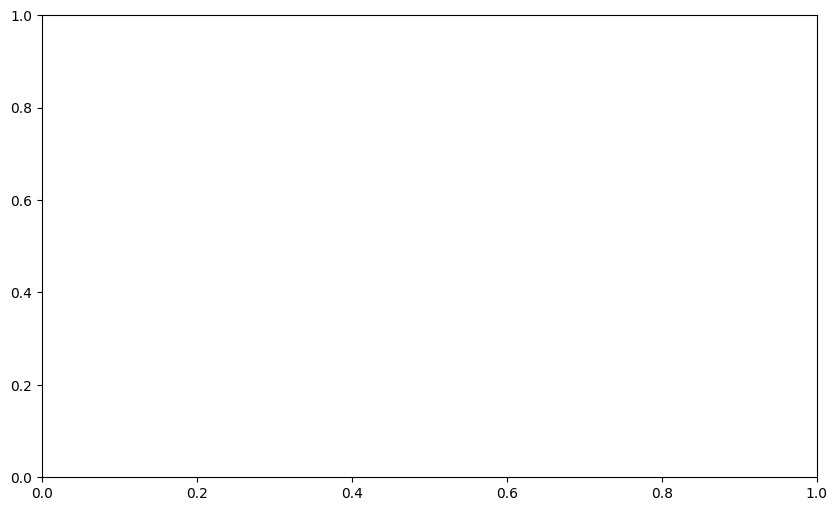

In [6]:

### Parameters ingeven
species = 'halsbandparkiet' # halsbandparkiet / boomklever
to_plot = "Waarnemingen" # Waarnemingen (per miljoen), Waarnemingen , Unieke waarnemers
to_plot_field = "hp_observations_abs"
to_plot_year = 2024

map_title = f"{to_plot} van de {species} per gemeente in {to_plot_year}"

vogels_per_gemeente_year = vogels_per_gemeente[vogels_per_gemeente["year"] == to_plot_year].copy()

#  plot defineren
fig, ax = plt.subplots(figsize=(10, 6))
vogels_per_gemeente_year = vogels_per_gemeente_year.to_crs(epsg=3857) # om de area te berekenen

vogels_per_gemeente_year["area"]= vogels_per_gemeente_year.area/1_000_000
vogels_per_gemeente_year["obs_km2"]= vogels_per_gemeente_year[to_plot_field]/vogels_per_gemeente_year["area"]

# Voorkom problemen met log(0)
vogels_per_gemeente_year["obs_km2"] = vogels_per_gemeente_year["obs_km2"].replace(0, np.nan)  # Vermijd log(0)
vogels_per_gemeente_year["obs_km2"] = vogels_per_gemeente_year["obs_km2"].fillna(vogels_per_gemeente_year["obs_km2"].min() / 10)

# Zet naar EPSG:4326 (Folium vereist WGS84-coördinaten)
vogels_per_gemeente_year = vogels_per_gemeente_year.to_crs(epsg=4326)

# Define colormap and normalization
cmap = cm.plasma  # Standard colormap
norm = colors.LogNorm(vmin=vogels_per_gemeente_year["obs_km2"].min(), vmax=vogels_per_gemeente_year["obs_km2"].max())

# Function to get color from colormap
def get_color(value):
    return colors.rgb2hex(cmap(norm(value)))

# Maak een folium kaart
title_html = f'''
    <h1 style="
        position:absolute;
        z-index:100000;
        left:40vw;
        background-color:white;
        padding:10px;
        border-radius:5px;
        box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
    ">
        {map_title}
    </h1>
'''
m = folium.Map(location=[50.85, 4.35], zoom_start=9)  # Midden België

# Voeg gemeenten toe met interactieve hover
for _, row in vogels_per_gemeente_year.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, row=row: {
            "fillColor": get_color(row["obs_km2"]),
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7,
        },
        tooltip=folium.Tooltip(f"{row['name']}: {row['obs_km2']:.3f} waarnemingen/km²"),
    ).add_to(m)
    
m.get_root().html.add_child(folium.Element(title_html))
m.save(f'{map_title}.html')